##### calculating training time benchmarks for various samples

In [6]:
import numpy as np
import pandas as pd

trees = pd.read_csv('../data/raw/new_york_tree_census_2015.csv')
# print(trees.columns)

target = trees['health']
keep_rows = target.notna()

drop_cols = ['health','tree_id', 'block_id', 'created_at', 'stump_diam','status','spc_common','problems','address',\
             'zip_city','cb_num', 'borocode', 'cncldist', 'st_assem', 'st_senate', 'nta', 'boro_ct', 'state',\
             'latitude', 'longitude']

group = ['nta_name']
spatial_geo = ['x_sp','y_sp'] # encode numerical, standardize
spatial_fine = ['zipcode'] # encode categorical
spatial_coarse = ['boroname'] # encode categorical

## base ftrs, without spatial ##
numerical_ftrs = ['tree_dbh']
categorical_ftrs = ['curb_loc', 'spc_latin', 'user_type', 'root_stone',
                    'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
                    'brch_light', 'brch_shoe', 'brch_other']
ordinal_ftrs = ['steward','guards','sidewalk']
ordinal_cats = [['None','1or2','3or4','4orMore'],
                ['None','Harmful','Unsure','Helpful'],
                ['Damage','None','NoDamage']]

In [7]:
# check we have accounted for all columns
listed = set(drop_cols).union(group,spatial_geo,spatial_fine,spatial_coarse,\
                              numerical_ftrs,categorical_ftrs,ordinal_ftrs)
print(set(trees.columns).difference(listed) == set())
# handle ordinal ftrs to fill in na
for ftr in ordinal_ftrs:
    trees[ftr] = trees[ftr].fillna('None')

True


In [ ]:
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

## DATA SAMPLING ##
RANDOM_STATE = 1
# define feature sets
drop_cols_set = drop_cols + group # + spatial_fine + spatial_coarse
categorical_ftrs_set = categorical_ftrs + spatial_fine + spatial_coarse
numerical_ftrs_set = numerical_ftrs + spatial_geo

y = target[keep_rows]
X = trees[keep_rows].drop(drop_cols_set, axis=1)
groups = trees[keep_rows][group]

def get_sample(X, y, groups, prop, random_state):
    SAMPLE_PROP = prop
    RANDOM_STATE = random_state
    ## hold out a test set by groups
    gss_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss_test.split(X, y, groups))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]
    ## sample 10% for cross validation
    X_sub, _, y_sub, _, groups_sub, _ = train_test_split(
        X_train, y_train, groups_train,
        train_size=SAMPLE_PROP,
        stratify=y_train,
        random_state=RANDOM_STATE
    )

    sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_sub
    )
    return X_train, X_test, X_sub, \
           y_train, y_test, y_sub, \
           groups_train, groups_test, groups_sub,\
           sample_weights

In [16]:
import timeit
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE=1

drop_cols_set = drop_cols + group # + spatial_fine + spatial_coarse
categorical_ftrs_set = categorical_ftrs + spatial_fine + spatial_coarse
numerical_ftrs_set = numerical_ftrs + spatial_geo

y = target[keep_rows]
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(y))

X = trees[keep_rows].drop(drop_cols_set, axis=1)
groups = trees[keep_rows][group]

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), categorical_ftrs_set),
        ('std', StandardScaler(), numerical_ftrs_set)])

# sample_proportions = [0.01, 0.05, 0.1, 0.2]
sample_proportions = np.linspace(0.01, 0.2, 25)
times = []

for prop in sample_proportions:

    datas = get_sample(X, y, groups, prop=prop, random_state=RANDOM_STATE)
    _, X_test, X_sub = datas[0:3]
    _, y_test, y_sub = datas[3:6]
    _, groups_test, groups_sub = datas[6:9]
    weights = datas[9:]

    clf = xgb.XGBClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=7,
                            n_jobs=-1,
                            random_state=RANDOM_STATE,
                            verbosity=1)
    pipeline = make_pipeline(preprocessor,clf)

    t1 = timeit.default_timer()

    pipeline.fit(X_sub, y_sub, xgbclassifier__sample_weight=weights)

    t2 = timeit.default_timer()

    times.append(t2-t1)

In [35]:
import timeit
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

RANDOM_STATE=1

drop_cols_set = drop_cols + group # + spatial_fine + spatial_coarse
categorical_ftrs_set = categorical_ftrs + spatial_fine + spatial_coarse
numerical_ftrs_set = numerical_ftrs + spatial_geo

y = target[keep_rows]
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(y))

X = trees[keep_rows].drop(drop_cols_set, axis=1)
groups = trees[keep_rows][group]

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), categorical_ftrs_set),
        ('std', StandardScaler(), numerical_ftrs_set)])

# sample_proportions = [0.01, 0.05, 0.1, 0.2]
sample_proportions_LR = np.linspace(0.01, 0.2, 15)
times_LR = []

for prop in sample_proportions_LR:

    datas = get_sample(X, y, groups, prop=prop, random_state=RANDOM_STATE)
    _, X_test, X_sub = datas[0:3]
    _, y_test, y_sub = datas[3:6]
    _, groups_test, groups_sub = datas[6:9]
    weights = datas[9:]

    clf = LogisticRegression(penalty='elasticnet',
                            solver='saga',
                            C=0.1,
                            l1_ratio=0.7,
                            class_weight='balanced',
                            n_jobs=-1,
                            max_iter=1000,
                            random_state=RANDOM_STATE,
                            verbose=False)
    pipeline = make_pipeline(preprocessor,clf)

    t1 = timeit.default_timer()

    pipeline.fit(X_sub, np.array(y_sub).ravel())

    t2 = timeit.default_timer()

    times_LR.append(t2-t1)

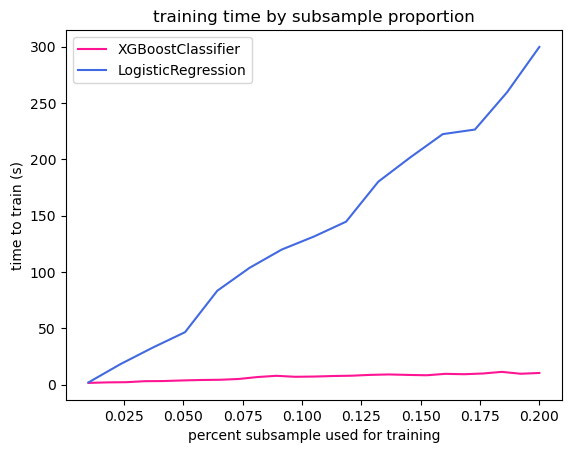

In [36]:
from matplotlib import pyplot as plt
plt.plot(sample_proportions, times, c='deeppink', label='XGBoostClassifier')
plt.plot(sample_proportions_LR, times_LR, c='royalblue', label='LogisticRegression')
plt.xlabel('percent subsample used for training')
plt.ylabel('time to train (s)')
plt.title('training time by subsample proportion')
plt.legend()
plt.savefig(
    '../reports/figures/both_train_time.png',
    dpi=600,
    transparent=True,
    bbox_inches='tight')
plt.show()